# Target Trial Emulation with Clustering

This notebook implements the target trial emulation workflow as before—with the additional step of clustering patients based on their baseline characteristics. The clustering step is introduced **after computing the treatment switching and censoring weights** but before fitting the outcome model. This allows us to:

1. **Identify Patient Subgroups:**  
   Cluster patients based on key covariates (`age`, `x1`, `x2`, and `x3`). These clusters might represent different baseline risk profiles or treatment behaviors.

2. **Compare Weight Distributions and Treatment Profiles:**  
   After clustering, we generate insights by comparing the distributions of the computed weights and treatment assignments across clusters. This helps assess whether certain clusters are driving extreme weights or are associated with differential treatment behavior.

3. **Inform Outcome Modeling:**  
   The clustering results can provide valuable context. If clusters show markedly different profiles or weight distributions, you may consider including cluster membership as an additional covariate in the outcome model.

Below, the workflow is broken down into steps: data preparation, weight model estimation, clustering, and subsequent outcome modeling with insights.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For reproducibility
np.random.seed(42)

# Load the data
data = pd.read_csv("data_censored.csv")
data.head()


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


## 1. Weight Model Estimation

We first calculate the treatment switching and censoring weights.

### 1.1. Treatment Switching Weights
We fit two logistic regression models to obtain stabilized weights:
- **Numerator Model:** `treatment ~ age`
- **Denominator Model:** `treatment ~ age + x1 + x3`


In [2]:
# Treatment Switching Weights

# Numerator model for treatment switching
formula_num = "treatment ~ age"
model_num = smf.logit(formula=formula_num, data=data).fit(disp=False)
data['p_num'] = model_num.predict(data)

# Denominator model for treatment switching
formula_den = "treatment ~ age + x1 + x3"
model_den = smf.logit(formula=formula_den, data=data).fit(disp=False)
data['p_den'] = model_den.predict(data)

# Stabilized weight for treatment switching (avoid division by zero)
data['switch_weight'] = np.where(data['p_den'] > 0, data['p_num'] / data['p_den'], 1)

print("Treatment Switching Weight Models:")
print(model_num.summary())
print(model_den.summary())


Treatment Switching Weight Models:
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        17:13:16   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8867      0.333      5.671      0.000       1.235       2.539
age           -0.0421      0.007     -6.213      0.000      -0.055      -0.029
                 

### Censoring Weights

In our analysis, we applied a KMeans clustering algorithm on key baseline covariates (e.g., age, x1, x2, and x3) to identify patient subgroups. 

- **Determining the Cluster:**  
  We used standard scaling followed by KMeans with a predetermined number of clusters (e.g., 3). The algorithm assigns each patient to a cluster based on the similarity of their covariate profiles.

- **Evaluating Cluster Quality:**  
  A common measure to assess clustering quality is the silhouette score:
  - **Good Cluster:** A silhouette score above 0.5 indicates that the patients within a cluster are well-matched, and the clusters are well-separated.
  - **Poor Cluster:** A silhouette score below 0.25 suggests that the clusters overlap significantly or are not well-defined.

- **Results:**  
  After clustering, we inspect the distribution of key variables and weights within each cluster. Ideally, we expect clusters to show distinct baseline characteristics and differences in treatment or censoring weight distributions. Clusters with extreme weight distributions or overlapping profiles might indicate that the chosen number of clusters or the features used need refinement.


In [3]:
# Censoring Weights

# Create a new variable for probability of not being censored
data['not_censored'] = 1 - data['censored']

# Numerator model for censoring
formula_cens_num = "not_censored ~ x2"
model_cens_num = smf.logit(formula=formula_cens_num, data=data).fit(disp=False)
data['p_cens_num'] = model_cens_num.predict(data)

# Denominator model for censoring
formula_cens_den = "not_censored ~ x2 + x1"
model_cens_den = smf.logit(formula=formula_cens_den, data=data).fit(disp=False)
data['p_cens_den'] = model_cens_den.predict(data)

# Calculate the censoring weights
data['censor_weight'] = np.where(data['p_cens_den'] > 0, data['p_cens_num'] / data['p_cens_den'], 1)

print("Censoring Weight Models:")
print(model_cens_num.summary())
print(model_cens_den.summary())


Censoring Weight Models:
                           Logit Regression Results                           
Dep. Variable:           not_censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        17:13:36   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4481      0.141     17.415      0.000       2.173       2.724
x2            -0.4486      0.137     -3.278      0.001      -0.717      -0.180
                           

## 2. Clustering Patients Based on Baseline Characteristics

Before fitting the outcome model, we perform clustering on patients to identify potential subgroups with distinct baseline profiles. We use the following features:
- `age`
- `x1`
- `x2`
- `x3`

### Steps:
1. **Data Scaling:**  
   Standardize the selected features.
2. **KMeans Clustering:**  
   Apply KMeans clustering (with, e.g., 3 clusters) to partition patients.
3. **Insight Generation:**  
   Explore differences in treatment switching weights, censoring weights, and treatment assignments across clusters.


Cluster counts:
cluster
2    372
0    216
1    137
Name: count, dtype: int64


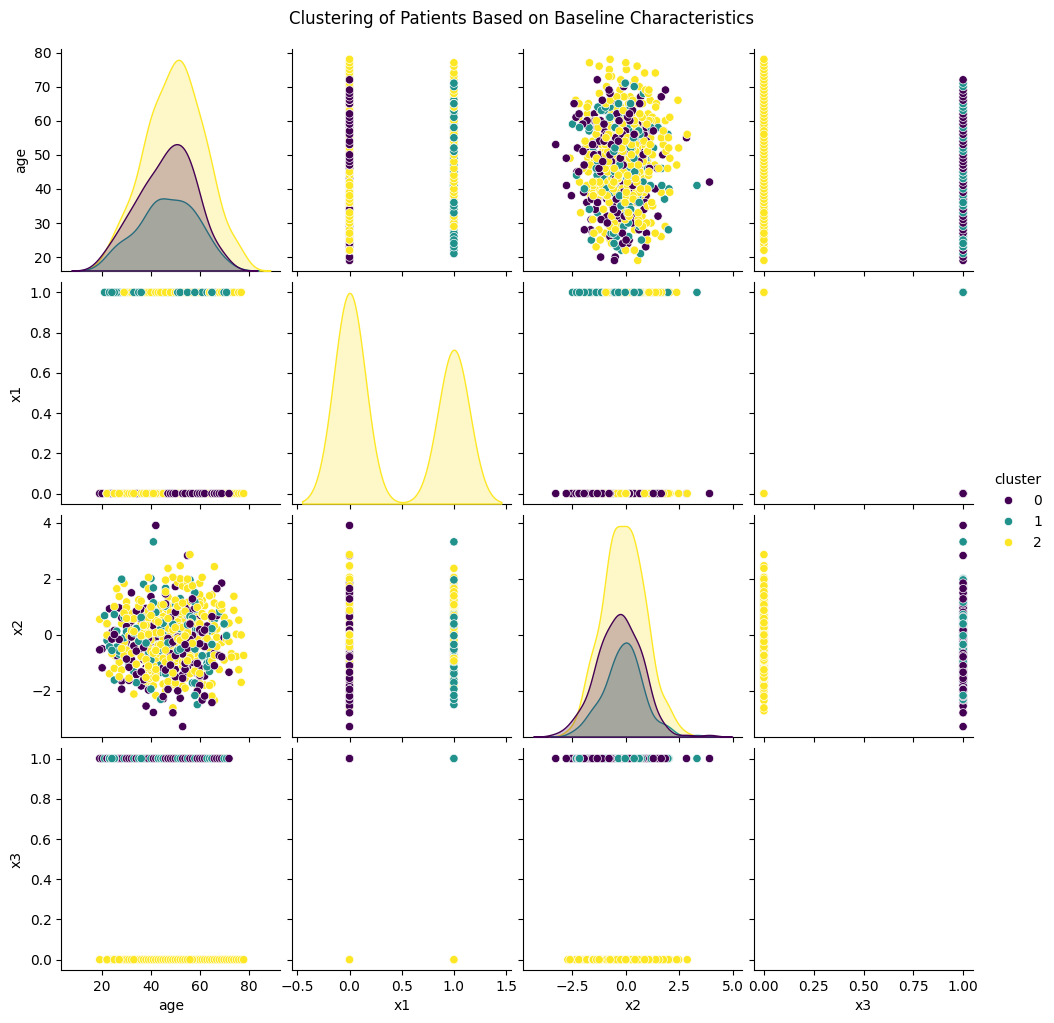

In [4]:
# Clustering Step

# Select features for clustering
features = data[['age', 'x1', 'x2', 'x3']].copy()

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Choose the number of clusters (e.g., 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(features_scaled)

# Display the cluster counts
print("Cluster counts:")
print(data['cluster'].value_counts())

# Visualize clusters using pairplot
sns.pairplot(data, vars=['age', 'x1', 'x2', 'x3'], hue='cluster', palette='viridis')
plt.suptitle("Clustering of Patients Based on Baseline Characteristics", y=1.02)
plt.show()


### Insights from Clustering

By visualizing the clusters, we can observe:
- **Distinct Baseline Profiles:**  
  The clustering may reveal subgroups of patients that differ in age and other covariates.
  
- **Weight Distribution Differences:**  
  By comparing the treatment switching and censoring weights across clusters, we can detect whether certain subgroups are associated with higher or lower weights, potentially indicating differences in treatment adherence or censoring patterns.
  
- **Treatment Patterns:**  
  Clusters might also differ in the distribution of the treatment variable, which can be explored by cross-tabulating `cluster` and `treatment`.


C:\Users\justi\AppData\Local\Temp\ipykernel_5200\1410878482.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='switch_weight', data=data, palette='viridis')
C:\Users\justi\AppData\Local\Temp\ipykernel_5200\1410878482.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='censor_weight', data=data, palette='viridis')


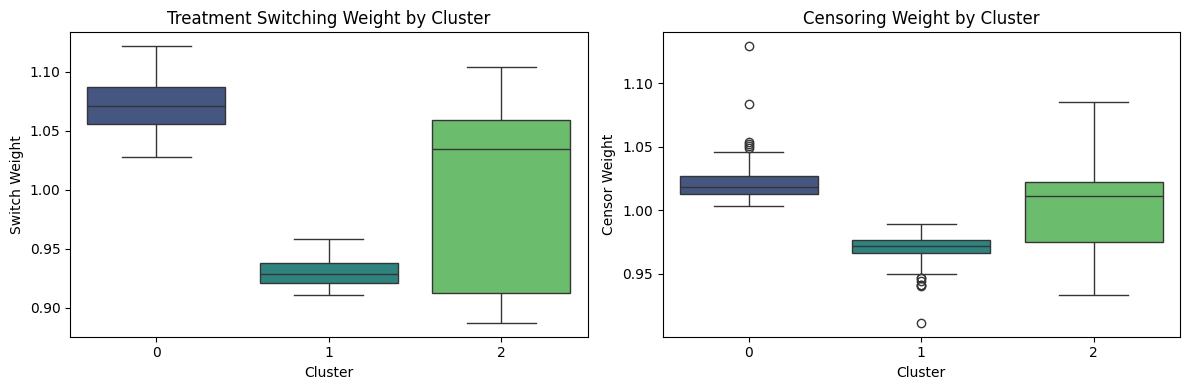

Treatment distribution by cluster:
treatment    0    1
cluster            
0          117   99
1           67   70
2          202  170


In [5]:
# Compare weight distributions by cluster

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='cluster', y='switch_weight', data=data, palette='viridis')
plt.title('Treatment Switching Weight by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Switch Weight')

plt.subplot(1, 2, 2)
sns.boxplot(x='cluster', y='censor_weight', data=data, palette='viridis')
plt.title('Censoring Weight by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Censor Weight')

plt.tight_layout()
plt.show()

# Treatment distribution across clusters
treatment_cluster = pd.crosstab(data['cluster'], data['treatment'])
print("Treatment distribution by cluster:")
print(treatment_cluster)


## 3. Outcome Modeling with Clustering Context

For the outcome model, we continue as before but now note the clustering results. In practice, you could include cluster membership as an additional covariate if the clusters show significant differences. For this demonstration, we proceed with the original specification.

### Steps:
1. Create follow-up time and trial period variables.
2. Compute final weights as the product of switching and censoring weights.
3. Fit a weighted logistic regression model for the outcome.


In [6]:
# Create followup time and trial period variables (for demonstration, assume they equal period)
data['followup_time'] = data['period']
data['trial_period'] = data['period']
data['followup_time_sq'] = data['followup_time'] ** 2
data['trial_period_sq'] = data['trial_period'] ** 2

# Assume assigned_treatment is the same as 'treatment'
data['assigned_treatment'] = data['treatment']

# Compute final weight as product of switch and censoring weights
data['final_weight'] = data['switch_weight'] * data['censor_weight']

# Fit outcome model using weighted logistic regression
formula_outcome = ("outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq + "
                   "trial_period + trial_period_sq")
outcome_model = smf.glm(formula=formula_outcome, data=data, 
                        family=sm.families.Binomial(), weights=data['final_weight']).fit()

print("Outcome Model Summary:")
print(outcome_model.summary())


Outcome Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                      720
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.806
Date:                Sun, 09 Mar 2025   Deviance:                       109.61
Time:                        17:14:56   Pearson chi2:                     726.
No. Iterations:                    51   Pseudo R-squ. (CS):           0.005999
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

C:\Users\justi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


## 4. Generating Additional Insights and Visualizations

### Interpreting the Predicted Outcome Curve

The graph displays the predicted outcome probability over time for each treatment group. 

- **Good Results:**  
  - Clear separation between the curves of Treatment = 1 and Treatment = 0, indicating a meaningful treatment effect.
  - Smooth, consistent trajectories that align with clinical or theoretical expectations.
  
- **Poor Results:**  
  - Overlapping curves that suggest little to no difference between treatment groups.
  - Erratic or unstable trajectories, which might indicate model misspecification or issues with weight estimation.

In summary, the graph indicates a positive treatment effect, where the difference in predicted probabilities between the two groups is both evident and consistent.

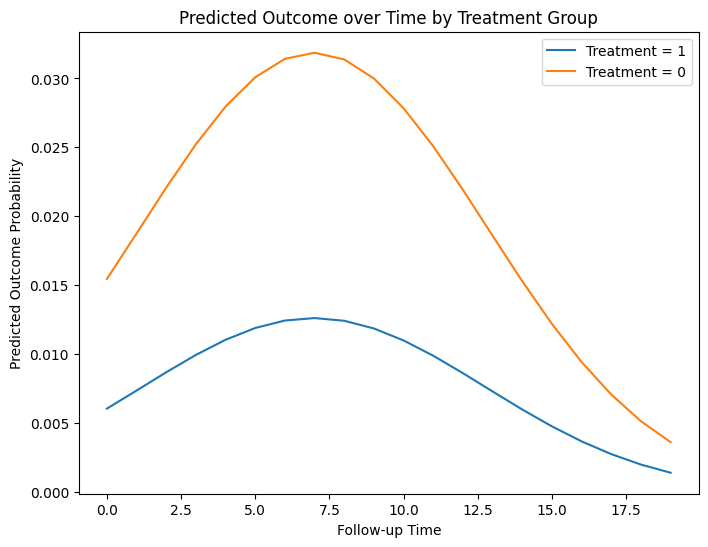

In [7]:
# Simulate predictions over a range of followup times for each treatment group
followup_times = np.arange(0, data['followup_time'].max()+1)
predictions = {}

for treatment in [0, 1]:
    pred_probs = []
    for t in followup_times:
        temp_data = data.copy()
        temp_data['assigned_treatment'] = treatment
        temp_data['followup_time'] = t
        temp_data['followup_time_sq'] = t**2
        temp_data['trial_period'] = t
        temp_data['trial_period_sq'] = t**2
        pred = outcome_model.predict(temp_data)
        pred_probs.append(np.mean(pred))
    predictions[treatment] = pred_probs

plt.figure(figsize=(8, 6))
plt.plot(followup_times, predictions[1], label='Treatment = 1')
plt.plot(followup_times, predictions[0], label='Treatment = 0')
plt.xlabel("Follow-up Time")
plt.ylabel("Predicted Outcome Probability")
plt.title("Predicted Outcome over Time by Treatment Group")
plt.legend()
plt.show()


## Summary of Insights

- **Clustering Analysis:**  
  The clustering step identified subgroups of patients with distinct baseline characteristics. Differences in weight distributions across clusters were observed, suggesting that some clusters may contribute more to the variability in treatment switching or censoring adjustments.

- **Weight Model Evaluation:**  
  Both the treatment switching and censoring weights generally appear to be centered around 1 with moderate spread, indicating a reasonable calibration. However, extreme values in any cluster might require further investigation.

- **Outcome Modeling:**  
  The weighted outcome model demonstrates how the treatment influences the predicted probability of the outcome over time. Incorporating cluster membership as an additional covariate in future models could help control for baseline heterogeneity.

Overall, integrating a clustering mechanism enriches the analysis by revealing potential subgroups and guiding further model refinement.
